![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/title.png)

## Who Am I?

Data scientist, teacher, author of the ***Deep Learning with PyTorch Step-by-Step*** series.

[![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/new_books.png)](https://pytorchstepbystep.com)

### Upcoming Book: The Ultimate Guide to Fine-Tuning LLMs with PyTorch and Hugging Face

<center><a href="https://leanpub.com/finetuning"><img src="https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/cover.png" width="200"/></a></center>
<br>
<h3><center>Visit <a href="https://leanpub.com/finetuning">leanpub.com/finetuning</a> and get a discount coupon when it's released!</center></h3>

## Agenda

- Why Fine-Tune?
- Types of Fine-Tuning
- The Main Challenge
- Loading a Quantized Base Model
- Formatting Your Dataset
- Setting Up Low-Rank Adapters (LoRA)
- Fine-Tuning with SFTTrainer

## Why Fine-Tune?

- Pretrained (base) models are **next word predictors**: they do not understand **questions** or **instructions** naturally.


- If prompted with a question, a base model is likely to reply with even **more questions** insteaf of answers.


- Fine-tuning can be used to:
  - **change the behavior** of the model
  - **change the style** of its answers
  - **increase its knowledge**

## Types of Fine-Tuning

- **Self-supervised fine-tuning**: it works by training the model to predict the next word - just like in (base) model pretraining.
  - it may be used to change **the style** of a model's answers to the user prompt
  - in self-supervised fine-tuning, **the labels are the same as the inputs**, except that they are **shifted** by one position


- **Supervised fine-tuning**: it works by training the model on **pairs of inputs/outputs** such as **question/answer** or **prompt/response**.
  - it may be used to teach the model how to **respond to user prompts** related to a given **domain**


- **Reinforcement-based fine-tuning**: it works by training the model on **labeled outputs** (good/bad or appropriate/inappropriate)
  - it may be used to **align the model** or **improve its answers**

## The Main Challenge

Fine-tuning LLMs feels like trying to fit this:

![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/elephant.png)

into this:

![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/beetle.png)

### Attention Is All You Need

- LLMs are Transformer Decoders
- The majority of the model's parameters are in the attention heads

![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/stacked_layers.png)

### We have MANY problems!

1. Base model takes a lot of space (p)
2. Optimizer's states (Adam) takes even more space (2p)
3. Gradients take a lot of space (p)
4. Activations take a lot of space, especially if the sequences are long
5. Attention is quadratic on the sequence length (10x longer => 100x more expensive to handle)

p = # of parameters

### Combine many solutions, we must!

1. ~~Base model takes a lot of space (p)~~

- **Solution**: **Quantization** reduces the model's memory footprint.

2. ~~Optimizer's states (Adam) takes even more space (2p)~~

- **Solutions**: While **8-bit Adam** may reduce the optimizer's memory footprint (especially if you're updating all parameters), **LoRA** drastically reduces the number of trainable parameters, thus making the optimizer a non-issue,

3. ~~Gradients take a lot of space (p)~~

- **Solutions**: **Checkpointing** trades compute for memory (discarding and recomputing values as they are needed, instead of caching them) and **LoRA** reduces the number of trainable parameters, so fewer gradients are computed overall.

4. ~~Activations take a lot of space, especially if the sequences are long~~

- **Solution**: **Checkpointing** once again trades compute for memory.

5. ~~Attention is quadratic on the sequence length (10x longer => 100x more expensive to handle)~~

- **Solution**: **Flash Attention** removes several inefficiencies of the original implementation, thus making memory requirements **linearly** proportional to sequence length! However, it only works on higher-end GPUs (it won't work on Colab).

## Setup

In [ ]:
!pip install -U transformers datasets trl bitsandbytes peft matplotlib

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, setup_chat_format
from matplotlib import pyplot as plt

## Loading a Quantized Based Model

### Model's Parameters (FP32)

![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/quant1.png)

Source:[Quantization Fundamentals with Hugging Face](https://www.deeplearning.ai/short-courses/quantization-fundamentals-with-hugging-face/)

### Quantizing Parameters (FP32 -> INT8)
![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/quant2.png)

Source:[Quantization Fundamentals with Hugging Face](https://www.deeplearning.ai/short-courses/quantization-fundamentals-with-hugging-face/)

In [22]:
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                             quantization_config=bnb_config
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


The quantized model takes up roughly 360 Mb or RAM, which is a little bit over 1/4 of its original size (1324 Mb).

In [23]:
print(model.get_memory_footprint()/1e6)

359.354368


Notice that all `Linear` layers were replaced by their `Linear8bitLt` quantized versions.

In [24]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear8bitLt(in_features=1024, out_features=512, bias=False)
      (project_in): Linear8bitLt(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear8bitLt(in_features=1024, out_features=4096, bias

## Formatting Your Dataset

<center><a href="https://imgflip.com/i/90l40r"><img src="https://i.imgflip.com/90l40r.jpg" title="made at imgflip.com"/></a><div></div></center>

The `SFTTrainer` we'll use later can handle a couple of default formats, namely:
- conversational format

```{"messages": [
    {"role": "system", "content": "You are helpful"},
    {"role": "user", "content": "What's the capital of France?"},
    {"role": "assistant", "content": "..."}
]}
```

- instruction format

```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
```

So, to make it easier to train, we're renaming the columns accordingly.

In [6]:
dataset = load_dataset("dvgodoy/yoda_sentences", split="train")
dataset = dataset.rename_column("sentence", "prompt")
dataset = dataset.rename_column("translation_extra", "completion")
dataset = dataset.remove_columns(["translation"])

README.md:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentences.csv:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

In [7]:
dataset[0]

{'prompt': 'The birch canoe slid on the smooth planks.',
 'completion': 'On the smooth planks, the birch canoe slid. Yes, hrrrm.'}

### Tokenizer

The tokenizer is an important piece of the process.

If we don't get the special tokens right, the model will either generate gibberish or be an annoying chatterbox.

A few important things to remember:

1. If you're padding, you should use **left** padding.

  - left-padding: `<|pad|><|pad|><|pad|>This is a short sentence.</s>`

  - right-padding: `This is a short sentence.<|pad|><|pad|><|pad|></s>`
  
Remember, LLMs are **decoders**, they predict the **next word** at the **end of the sentence**.

Right-padding makes it too easy for the LLM to generate endless sequences of `<|pad|>` tokens.

You do not want that.

2. **DO NOT** set the **padding token** to be the same as the **EOS (ending) token**.

  - proper padding token: `<|pad|><|pad|><|pad|>This is a short sentence.</s>`

  - EOS as padding token: `</s></s></s>This is a short sentence.</s>`

Using the EOS token as padding token **will** confuse the model, as it will learn that there may be more words after the EOS token (because **there are** words after the left-padded tokens.

You do no want that either.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    model.config._name_or_path,
    padding_side='left',
    pad_token='<|pad|>',
)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [9]:
tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token

('<|pad|>', '</s>', '</s>')

Now that we have both model and tokenizer, we can take them for a spin and use them to generate a few words.

Notice that it still is the base pretrained model. It does not know instructions, and it does not know Yoda.

In [25]:
def generate(model, tokenizer, prompt, max_new_tokens=100):
    tokenized_input = tokenizer(prompt, add_special_tokens=False, return_tensors="pt")
    input_ids = tokenized_input["input_ids"].cuda()

    model.eval()
    generation_output = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
    output = tokenizer.batch_decode(generation_output, skip_special_tokens=False)[0]
    return output

In [26]:
print(generate(model, tokenizer, 'The Force is strong in you!'))

The Force is strong in you!
I'm not sure if I'm ready to be a Jedi.
I'm not sure if I'm ready to be a Jedi.
I'm not sure if I'm ready to be a Jedi.
I'm not sure if I'm ready to be a Jedi.
I'm not sure if I'm ready to be a Jedi.
I'm not sure if I'm ready to be a Jedi.
I'm not sure if I'm ready to be a Jedi.
I


#### Chat Template

We're trusting that `SFTTrainer` will handle our dataset appropriately, since we renamed the columns accordingly.

It **will**, but **only** if the provided tokenizer has a **chat template**, that is, if it specifies the following:

- which special tokens should be used and where they should be placed
- where the specified columns (`prompt` and `completion`) should be placed
- what is the **generation prompt** (more on that in the last section)

In [13]:
tokenizer.chat_template

Unfortunately, our model/tokenizer does not come with a chat template.

It makes sense, since the base model was not fine-tuned for instructions.

However, we can define a template or, better yet, use [ChatML](https://github.com/openai/openai-python/blob/release-v0.28.0/chatml.md) as default template calling the `setup_chat_format()` function.

**IMPORTANT #1**: the `setup_chat_format()` function forcibly resize the embedding layers to match the tokenizer's vocabulary length.

However, most models have **spare space** in their embedding layers, meaning it is possible to **add extra tokens without resizing the embedding layers**.

For performance reasons, it is commonplace to keep the embedding layer's length as a multiple of a power of 2 (that's what we're doing in the `resize_to_multiple_of` argument since our model's embedding layer has 50,272 elements while the tokenizer has only 50,266).

**IMPORTANT #2**: if your model's embedding layer gets resized (whether it's shorter or longer than it was), you'll **have to save the embeddings** after fine-tuning, thus making your adapter larger, and requiring extra steps for loading it afterward.

**IMPORTANT #3**: the `setup_chat_format()` function **sets the EOS token as the pad token**, effectively undoing what we did above, so we need to fix it once again.

In [14]:
if tokenizer.chat_template is None:
    model, tokenizer = setup_chat_format(model, tokenizer, resize_to_multiple_of=32)

In [15]:
tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token

('<|im_end|>', '<|im_end|>', '<|im_start|>')

Uh-oh! Unfortunately, the function does exactly what I advised you **not** to do: the padding token was set to be the same as the EOS token.

Let's fix it:

In [16]:
tokenizer.pad_token = '<|pad|>'
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token

('<|pad|>', '<|im_end|>', '<|im_start|>')

Now, let's see how it will format an example from our dataset:

In [17]:
messages = [
    {"role": "user", "content": dataset[0]['prompt']},
    {"role": "assistant", "content": dataset[0]['completion']}
]
print(tokenizer.apply_chat_template(messages, tokenize=False))

<|im_start|>user
The birch canoe slid on the smooth planks.<|im_end|>
<|im_start|>assistant
On the smooth planks, the birch canoe slid. Yes, hrrrm.<|im_end|>



Notice that each interaction is wrapped in `<|im_start|>` and `<im_end|>` tokens.

## Setting Up Low-Rank Adapters (LoRA)

### What is LoRA?

LoRA is a **parameter-efficient fine-tuning (PEFT)** technique that attaches **adapters** to linear layers (mostly in attention heads) to allow models to be fine-tuned without updating the base model's parameters.

![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/lora.png)

In [18]:
# Without LoRA
def regular_forward_matmul(x, W):
    h = x @ W
    return h

# With LoRA
def lora_forward_matmul(x, W, W_A, W_B, alpha):
    h = x @ W
    h += x @ (W_A @ W_B)*alpha

$$
\Large
W_{\text{LoRA}} = W_{\text{orig}}+\frac{\alpha}{r}\Delta W = W_{\text{orig}}+\frac{\alpha}{r}BA
$$

![](https://raw.githubusercontent.com/dvgodoy/FineTuningLLMs101_ODSC_Europe2024/main/images/lora_diagram.png)
Source: [PEFT documentation](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#merge-lora-weights-into-the-base-model)

### PEFT

It is a library for efficiently adapting large pretrained models. It is integrated with the Transformers, Diffusers, and Accelerate libraries.

#### Steps:

1. Instantiate a base model (done!)
2. Prepare the model using the `prepare_model_for_kbit_training()` method (cell below)
3. Create an instance of the configuration ([`LoraConfig`](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft)) object (cell below)
4. Apply the LoRA configuration to the base model using the `get_peft_model()` method (cell below)
5. Train the PEFT model as you would normally train any other model (next section)

In [27]:
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8,                   # the rank of the adapter, the lower the fewer parameters you'll need to train
    lora_alpha=16,         # multiplier, usually 2*r
    bias="none",           # BEWARE: training biases *modifies* base model's behavior
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 512, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
          (project_out): Linear8bitLt(in_features=1024, out_features=512, bias=False)
          (project_in): Linear8bitLt(in_features=512, out_features=1024, bias=False)
          (layers): ModuleList(
            (0-23): 24 x OPTDecoderLayer(
              (self_attn): OPTSdpaAttention(
                (k_proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features

Notice that the attention layers (`v_proj`, and `q_proj`) which already were quantized (`Linear8bitLt`), now have a set of several much smaller LoRA-related `Linear` layers attached to them.

These extra layers will make the model slightly larger:

In [28]:
print(model.get_memory_footprint()/1e6)

418.816


But, overall, only a tiny fraction of the total number of parameters is trainable now, thanks to LoRA!

In [29]:
trainable_parms, tot_parms = model.get_nb_trainable_parameters()
print(trainable_parms/1e3)
print(100*trainable_parms/tot_parms)

786.432
0.2368893467652883


## Fine-Tuning with SFTTrainer

The `SFTTrainer` (Supervised Fine-Tuning Trainer) object takes:
- a model
- a tokenizer
- a dataset
- a configuration object

We already have the first three elements, let's work on the last one.

### `SFTConfig`

#### Gradient Checkpointing

This is an overlooked hero in most tutorials.

The memory gains, if the sequences are long (e.g. 1,000 tokens), are HUGE.

#### Gradient Accumulation

Next to the huge elephant (the LLM) we must be able to fit **at least one data point** in the GPU RAM.

A mini-batch of one is no fun, though, so we turn to **gradient accumulation**.

The mini-batch size (`per_device_train_batch_size`) will actually stand for a **micro-batch** which works as an intermediate step. After a few micro-batches (`gradient_accumulation_steps`), the model update will be triggered.

The effective mini-batch size is: `gradient_accumulation_steps` x `per_device_train_batch_size`

#### Auto-find Batch Size

Is there anything more annoying than OOM errors? Do you like trying out mini/micro batch sizes on your own? Me neither!

If set to `True`, it will start with `per_device_train_batch_size` and, should it result in OOM error, it halves the size and try again until it works.

#### Optim

The optimizer it should use. We can choose a paged 8-bit optimizer (`"paged_adamw_8bit"`) to squeeze the most space out of it.

In our case, though, it won't make much of a difference since LoRA reduced the number of trainable parameters to a handful.

#### Max Sequence Length

The sequence length is one of the main drivers of memory usage, especially since we cannot use Flash Attention.

So, we should choose a value that's not much more than what we actually need.

How long are our sequences (considering **both** prompt and completion, that is):

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

(array([  5.,  18.,  91.,  55., 224., 136., 128.,  23.,  31.,   9.]),
 array([10. , 11.5, 13. , 14.5, 16. , 17.5, 19. , 20.5, 22. , 23.5, 25. ]),
 <BarContainer object of 10 artists>)

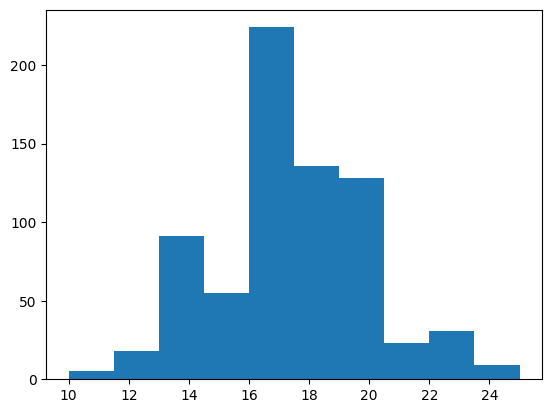

In [30]:
plt.hist(dataset.map(lambda row: {'len': len(row['prompt'].split()) + len(row['completion'].split())})['len'])

The longest sequences have 25 words.

That's roughly 30 tokens (as a rule of thumb, **1 token = 0.8 word**).

We'll also add some special tokens to it, so it's surely shorter than 40 tokens in total.

We may give the user some wiggle room to come up with slightly longer sentences, so let's make it 64 tokens.

In [37]:
sft_config = SFTConfig(
    # Checkpointing
    gradient_checkpointing=True,    # this saves a LOT of memory
    gradient_checkpointing_kwargs={'use_reentrant': False}, # set this to avoid exceptions in newer versions of PyTorch
    # Gradient Accumulation / Batch size
    gradient_accumulation_steps=4,  # actual batch (for updating) is 4x micro-batch size
    per_device_train_batch_size=8,  # the initial (micro) batch size to start off with
    auto_find_batch_size=True,      # if (micro) batch size would cause OOM, halves its size until it works
    # Optimizer
    optim='paged_adamw_8bit',       # 8-bit Adam optimizer - doesn't help much if you're using LoRA!
    # Seq Length
    max_seq_length=64,
    ## These are typical training parameters
    num_train_epochs=10,            # 10 epochs take about 10 minutes on Colab's T4 GPU
    learning_rate=3e-4,
    logging_steps=10,
    logging_dir="./logs",
    output_dir='./tmp',
    report_to='none'
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=sft_config,
    train_dataset=dataset,
)

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


The `SFTTrainer` had already preprocessed our dataset, so we can peek inside and see how each mini-batch was assembled:

In [32]:
dl = trainer.get_train_dataloader()
batch = next(iter(dl))

The mini-batch has eight elements as specified in the `per_device_train_batch_size` argument:

In [33]:
len(batch['input_ids'])

8

Let's check the labels, after all, we didn't provide any, right?

In [34]:
batch['input_ids'][0], batch['labels'][0]

(tensor([50265, 50265, 50265, 50265, 50265, 50265, 50265, 50265, 50266, 12105,
         50118,  1213,   362,    49,  1159,    31,     5,   285,   334,     4,
         50267, 50118, 50266,  2401, 33388, 50118,  7605,     5,   285,   334,
             6,    49,  1159,    51,   362,     4,   289,   338, 41311,     4,
         50267, 50118], device='cuda:0'),
 tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 50266, 12105,
         50118,  1213,   362,    49,  1159,    31,     5,   285,   334,     4,
         50267, 50118, 50266,  2401, 33388, 50118,  7605,     5,   285,   334,
             6,    49,  1159,    51,   362,     4,   289,   338, 41311,     4,
         50267, 50118], device='cuda:0'))

The **labels were added automatically, and they are exactly the same as the inputs** (thus making this a case of self-supervised fine-tuning).

The shifting of the labels is going to be handled automatically as well, there's no need to be concerned about it.

Did you notice there's a difference in the beginning of both sequences? Can you guess which token that is?

In [35]:
tokenizer.convert_ids_to_tokens(50265)

'<|pad|>'

### Training

Now, we call the `train()` method and wait. It takes around 10 minutes to train for 10 epochs using Colab:

In [38]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
10,3.854800
20,2.581800
30,2.032500
40,1.815400
50,1.653700
60,1.564600
70,1.530200
80,1.459700
90,1.459300
100,1.421500


TrainOutput(global_step=220, training_loss=1.6201479825106535, metrics={'train_runtime': 514.22, 'train_samples_per_second': 14.002, 'train_steps_per_second': 0.428, 'total_flos': 513663367249920.0, 'train_loss': 1.6201479825106535, 'epoch': 9.777777777777779})

After 10 epochs, the loss should be around 1.4. After 30 epochs. around 1.2.

### Loading the Adapter from the Hub

I have already trained the model for 30 epochs and pushed it to the hub, so we can try it right away without having to wait for the training process to finish. Moreover, since we modified the tokenizer, I have pushed it to the hub as well.

In [48]:
# After training, I pushed it to the hub like this
# from huggingface_hub import login
# login()
# trainer.model.push_to_hub('dvgodoy/opt-350m-lora-yoda')
# trainer.tokenizer.push_to_hub('dvgodoy/opt-350m-lora-yoda')

tokenizer = AutoTokenizer.from_pretrained("dvgodoy/opt-350m-lora-yoda")
model = AutoModelForCausalLM.from_pretrained("dvgodoy/opt-350m-lora-yoda", device_map='auto')

# overwriting the model in the trainer as well, so we can save it as if it were fully trained
trainer.model = model
trainer.tokenizer = tokenizer

tokenizer_config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.


## Trying Our Model

Now, our model *should* be able to understand the chat template, and produce a Yoda-like sentence as a response to any (short) sentence we provide it.

So, the model requires its inputs to be formatted as such. We need to build a list of "messages" (only ours, the `user`, in this case) and - literally - **prompt** the model to answer by indicating it is **its turn to write**.

This is the purpose of the `add_generation_prompt` argument: it adds `<|im_start|>assistant` to the end of the conversation, so the model can predict the next word (and again and again, until it predicts an `<|endoftext|>` token.

In [39]:
def gen_prompt(tokenizer, sentence, add_generation_prompt=True):
    converted_sample = [
        {"role": "user", "content": sentence},
    ]
    prompt = tokenizer.apply_chat_template(converted_sample, tokenize=False, add_generation_prompt=True)
    return prompt

In [49]:
sentence = 'Do not give up so soon!'
prompt = gen_prompt(tokenizer, sentence)
print(prompt)

<|im_start|>user
Do not give up so soon!<|im_end|>
<|im_start|>assistant



The prompt seems about right, let's use it to generate a completion:

In [50]:
print(generate(model, tokenizer, prompt))

<|im_start|>user
Do not give up so soon!<|im_end|>
<|im_start|>assistant
So soon, do not give up, you must.<|im_end|>


Awesome! It works!

If you trained it for 10 epochs only, it works well most of the time. If you train it for longer, say, 30 epochs, it will be even better.

Let's try a few more sentences:

In [51]:
sentence = 'Jump over the lazy fox.'
print(generate(model, tokenizer, gen_prompt(tokenizer, sentence)))

<|im_start|>user
Jump over the lazy fox.<|im_end|>
<|im_start|>assistant
Over the lazy fox, jump, you must.<|im_end|>


In [52]:
sentence = 'The Force is strong in this one!'
print(generate(model, tokenizer, gen_prompt(tokenizer, sentence)))

<|im_start|>user
The Force is strong in this one!<|im_end|>
<|im_start|>assistant
Strong in this one, the Force is.<|im_end|>


In [53]:
sentence = 'Fine-tuning LLMs is easy.'
print(generate(model, tokenizer, gen_prompt(tokenizer, sentence)))

<|im_start|>user
Fine-tuning LLMs is easy.<|im_end|>
<|im_start|>assistant
Easy, fine-tuning LLMs is.<|im_end|>


We can also try a sentence from the training set itself:

In [54]:
i = 235
print(generate(model, tokenizer, gen_prompt(tokenizer, dataset[i]['prompt'])))
print(f"\nCompletion:\n{dataset[i]['completion']}")

<|im_start|>user
Whitings are small fish caught in nets.<|im_end|>
<|im_start|>assistant
In nets, small fish caught, whitings are.<|im_end|>

Completion:
Caught in nets, small fish, whitings are. Yes, hrrmmm.


In [55]:
sentence = 'The model speaks like Yoda.'
print(generate(model, tokenizer, gen_prompt(tokenizer, sentence)))

<|im_start|>user
The model speaks like Yoda.<|im_end|>
<|im_start|>assistant
Like Yoda, the model speak.<|im_end|>


**Like Yoda, the model speaks. Yes, hrmm.**

## Saving The Model

You may also save both adapter and tokenizer to disk, instead of pushing them to the hub:

In [47]:
# trainer.save_model('yoda_adapter')

# it is equivalent to saving both model and tokenizer
trainer.model.save_pretrained('yoda_adapter')
# if you modified the tokenizer, you need to save it as well
trainer.tokenizer.save_pretrained('yoda_adapter')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('yoda_adapter/tokenizer_config.json',
 'yoda_adapter/special_tokens_map.json',
 'yoda_adapter/vocab.json',
 'yoda_adapter/merges.txt',
 'yoda_adapter/added_tokens.json',
 'yoda_adapter/tokenizer.json')

## BONUS

### Loading with Resized Embeddings

If your embeddings were resized, you'd need to load the base model first, resize its embeddings accordingly, and **only then** load your adapter using `PeftModel.from_pretrained()` instead:

In [ ]:
from peft import PeftModel

loaded_tokenizer = AutoTokenizer.from_pretrained('yoda_adapter')
base_model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", device_map='auto')
num_embeddings = base_model.get_input_embeddings().num_embeddings
if num_embeddings < len(loaded_tokenizer):
  base_model.resize_token_embeddings(len(loaded_tokenizer))
model_to_merge = PeftModel.from_pretrained(base_model, 'yoda_adapter')
model_to_merge

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 512, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
          (project_out): Linear(in_features=1024, out_features=512, bias=False)
          (project_in): Linear(in_features=512, out_features=1024, bias=False)
          (layers): ModuleList(
            (0-23): 24 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=8, bias=False)

### Merging Adapters

It is also possible to merge the adapters into the base model, resulting in what would have been the result of directly fine-tuning the linear layers that were adapted. It is as simgple as calling the (adapted) model's `merge_and_unload()` method:

In [ ]:
merged_model = model_to_merge.merge_and_unload()
merged_model.save_pretrained('yoda_model')
merged_model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=409

Let's take the merged model for a quick spin to make sure it is working fine:

In [ ]:
sentence = 'Jump over the lazy fox.'
print(generate(merged_model, tokenizer, gen_prompt(tokenizer, sentence)))

<|im_start|>user
Jump over the lazy fox.<|im_end|>
<|im_start|>assistant
Over the lazy fox, jump, you must.<|im_end|>


And that's a wrap!

Now, it's your time to try and fine-tune your own models!

<center><h1>THANK YOU!</h1></center>